# 🎯 Goal

> 각각의 대출 신청자들이 대출금을 상환할 능력이 얼마나 되는지 예측하기

`TARGET` 1은 대출 상환에 어려움을 겪는 고객을 의미한다.

# 🧭 Data

`application_{train|test}.csv`
- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

`bureau.csv`

- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

`bureau_balance.csv`

- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

`POS_CASH_balance.csv`

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

`credit_card_balance.csv`

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

`previous_application.csv`

- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

`installments_payments.csv`

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

`HomeCredit_columns_description.csv`

- This file contains descriptions for the columns in the various data files.

# 📖 Read Data

In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from bayes_opt import BayesianOptimization  ## pip install bayesian-optimization 필요

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(os.listdir("../Eunhee/input/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
train = pd.read_csv('../Eunhee/input/application_train.csv')
print("Training data shape :", train.shape)
train.head()

Training data shape : (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
test = pd.read_csv('../Eunhee/input/application_test.csv')
print("Testing data shape :", test.shape)
test.head()

Testing data shape : (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# 🔎 EDA

In [5]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

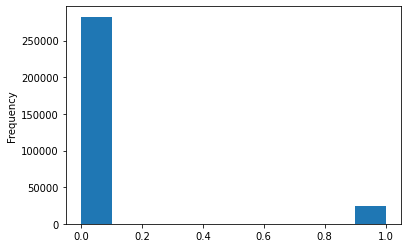

In [6]:
train['TARGET'].plot.hist()

데이터의 불균형성(imbalanced) 분제가 발생하기 때문에, 불균형 데이터셋의 균형을 유지할 수 있도록 조치가 필요하다.

In [7]:
# Function to calculate missing values
def missing_values_table(df):
    # Sum and percentage of missing values by each columns
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table.rename(columns={0:'Total counts', 1:'% of Missing'}
                         , inplace=True)
    
    # Sort the table by percentage of missing descending
    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0].sort_values(
    '% of Missing', ascending=False).round(1)
    
    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
         "There are " + str(mis_val_table.shape[0]) + " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table

In [8]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Total counts,% of Missing
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [9]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [10]:
train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Label Encoding

<img src="https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png">

범주가 2개뿐인 변수들에 대해서 label encoding을 진행한다. 모든 범주형 변수들에 대해 label encoding을 진행하면 범주들에 대해 임의의 순위가 생기기 때문이다.

In [11]:
le = LabelEncoder()
le_count = 0

for col in train:
    if train[col].dtype == 'object':
        # If 2 of fewer unique categories
        if len(list(train[col].unique())) <= 2:
            le.fit(train[col])
            # Transform by each train[col]
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # How many columns were label encoded
            le_count += 1

print('%d columns were label encoded.'%le_count)

3 columns were label encoded.


In [12]:
train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

CODE_GENDER                    3
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [13]:
train.shape

(307511, 122)

## One-Hot Encoding

<img src="https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png">

그 외의 범주형 변수들에 대해서는 one-hot encoding을 진행한다. 

In [14]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print("Training data shape :", train.shape)
print("Testing data shape :", test.shape)

Training data shape : (307511, 243)
Testing data shape : (48744, 239)


## Managing NA


## Aligning Training and Testing Data

Training data와 testing data의 교집합만을 가져오고, training data에 다시 `TARGET` 컬럼을 붙여 준다.

In [15]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_labels = train['TARGET']
train, test = train.align(test, join='inner', axis=1)

train['TARGET'] = train_labels

print("Training data shape :", train.shape)
print("Testing data shape :", test.shape)

Training data shape : (307511, 240)
Testing data shape : (48744, 239)


## Anomalies

`DAYS_BIRTH`의 경우, 'Client's age in days at the time of application' 으로  신청 시점 기준으로 나이를 계산하기 위해서는 -365로 나누어 주어야 한다.

### `DAYS_BIRTH`

In [17]:
train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [18]:
(train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [19]:
train['DAYS_BIRTH'] = -train['DAYS_BIRTH']

Text(0, 0.5, 'Count')

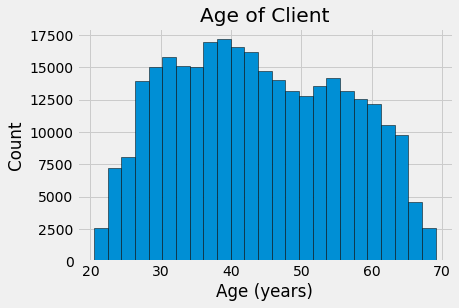

In [20]:
plt.style.use('fivethirtyeight')
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

### `DAYS_EMPLOYED`

In [21]:
train['DAYS_EMPLOYED'].nlargest(5)

8     365243
11    365243
23    365243
38    365243
43    365243
Name: DAYS_EMPLOYED, dtype: int64

In [22]:
(train['DAYS_EMPLOYED'] == 365243).sum()

55374

<AxesSubplot:ylabel='Frequency'>

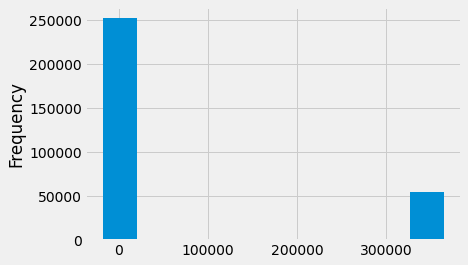

In [23]:
train['DAYS_EMPLOYED'].plot.hist()

In [24]:
anom = train[train['DAYS_EMPLOYED'] == 365243]
non_anom = train[train['DAYS_EMPLOYED'] != 365243]

print('The non-anomalies default on %0.2f%% of loans' %(100*non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' %(100*anom['TARGET'].mean()))
print('There are %d anomalous days of employment' %len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


<AxesSubplot:ylabel='Frequency'>

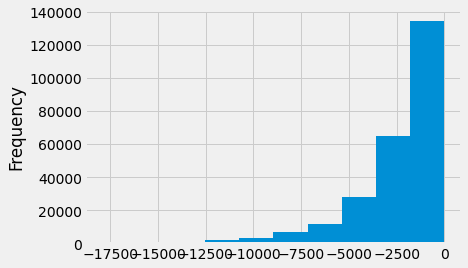

In [25]:
train['DAYS_EMPLOYED_ANOM'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
train['DAYS_EMPLOYED'].plot.hist()

`np.nan`으로 설정한 이상치 `DAYS_EMPLOYED_ANOM` 컬럼은 이후 mean imputation을 통해 평균값으로 채우고자 한다.

In [26]:
test['DAYS_EMPLOYED_ANOM'] = test['DAYS_EMPLOYED'] == 365243
test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

print('There are %d anomalies in the test data out of %d entries' % (test['DAYS_EMPLOYED_ANOM'].sum(), len(test)))

There are 9274 anomalies in the test data out of 48744 entries


## Correlations

In [27]:
correlations = train.corr()['TARGET'].sort_values()

In [28]:
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

`DAYS_BIRTH`가 가장 큰 양의 상관관계를 보인다.

### Age(`DAYS_BIRTH`)의 영향력

In [29]:
train['TARGET']

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [30]:
abs(train['DAYS_BIRTH']).corr(train['TARGET'])

-0.07823930830982709

나이듦과 상환능력 없음이 음의 상관관계를 가진다. 이는 <u>나이가 들수록 상환능력이 있음</u>을 의미한다. 

In [31]:
train.loc[train['TARGET']==0, 'DAYS_BIRTH']

1         16765
2         19046
3         19005
4         19932
5         16941
          ...  
307505    24384
307506     9327
307507    20775
307508    14966
307510    16856
Name: DAYS_BIRTH, Length: 282686, dtype: int64

Text(0.5, 1.0, 'Distribution of Ages')

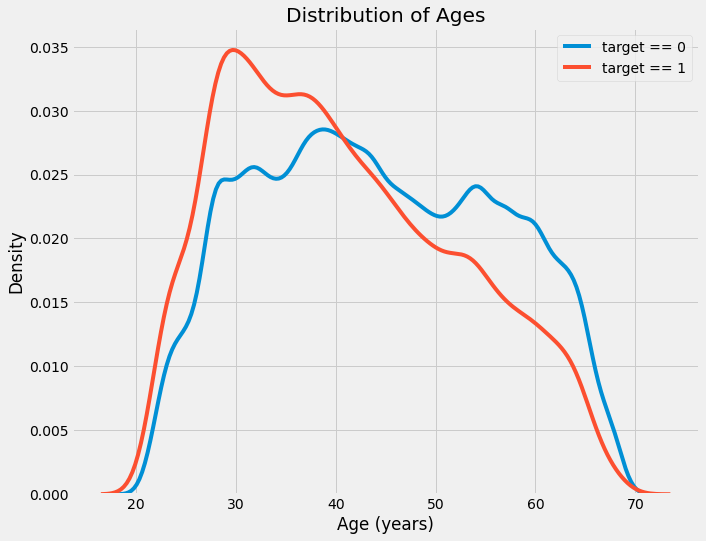

In [32]:
plt.figure(figsize=(10, 8))

sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='target == 0')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='target == 1')

plt.legend()

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

### `EXT_SOURCE`의 영향력

`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`이 가장 큰 음의 상관관계를 보인다. `EXT_SOURCE`는 외부 data source로부터의 normalized score라는 설명이 전부이다.

In [33]:
target_ext_birth_corr = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr()
target_ext_birth_corr

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

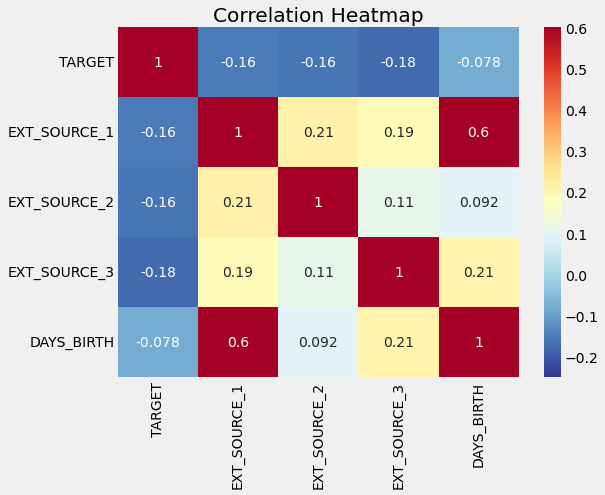

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(target_ext_birth_corr, cmap='RdYlBu_r', vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

- correlation에서 확인한 것처럼, 모든 `EXT_SOURCE`는 `TARGET`과 음의 상관관계를 가진다. 즉, <u>`EXT_SOURCE`가 증가할수록 상환능력이 있음</u>을 의미한다.
- `EXT_SOURCE_1`과 `DAYS_BIRTH`는 양의 상관관계를 가진다.

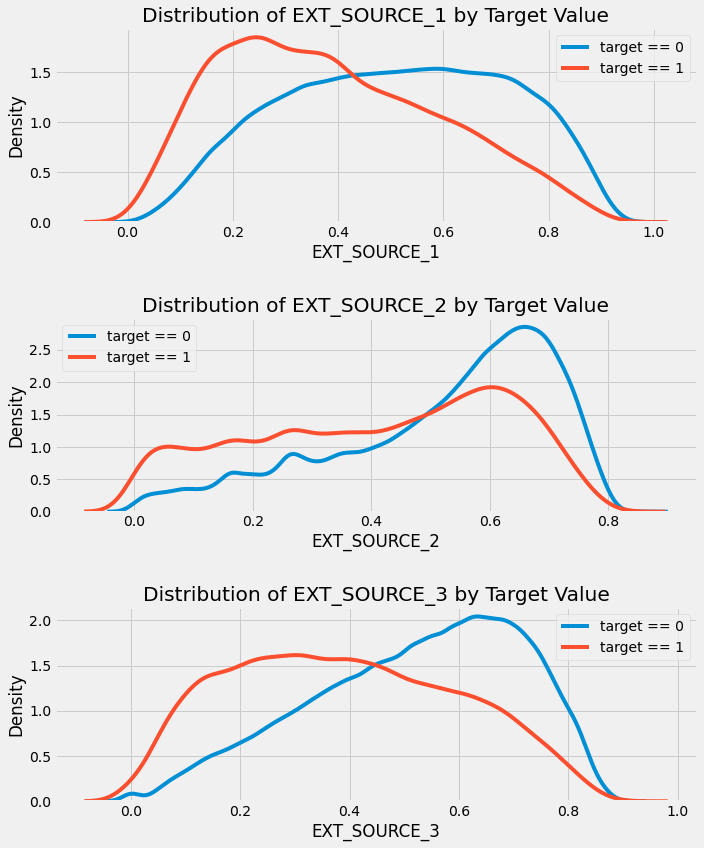

In [35]:
plt.figure(figsize=(10,12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i+1)
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label='target == 0')
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label='target == 1')
    
    plt.legend()
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')

plt.tight_layout(h_pad=2.5)

# Feature Engineering

## Polynomial Features

In [36]:
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

imputer = SimpleImputer(strategy='median')

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns=['TARGET'])

poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

poly_transformer = PolynomialFeatures(degree=3)

In [37]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features shape :', poly_features.shape)

Polynomial Features shape : (307511, 35)


In [38]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'][:15])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

이렇게 만들어진 polynomial term들이 예측하고자 하는 `TARGET`과 어떠한 상관관계를 가지고 있는지 분석해 보자.

In [39]:
poly_features = pd.DataFrame(poly_features,
                            columns=poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                       'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target

poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


원래의 feature들보다 새롭게 만든 feature들이 `TARGET`과 상관관계가 더 뚜렷하게 나타난다. 머신러닝 모델을 만들 때에는 이러한 feature들을 포함하거나 포함하지 않는 방식으로 시도함으로써 이들이 모델 학습에 실질적으로 도움이 되는지를 확인할 수 있다.

In [40]:
poly_features_test = pd.DataFrame(poly_features_test,
                                 columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                              'EXT_SOURCE_3', 'DAYS_BIRTH']))

In [41]:
poly_features['SK_ID_CURR'] = train['SK_ID_CURR']
train_poly = train.merge(poly_features, on='SK_ID_CURR', how='left')

poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
test_poly = test.merge(poly_features_test, on='SK_ID_CURR', how='left')

train_poly, test_poly = train_poly.align(test_poly, join='inner', axis=1)

print('Training data with polynomial features shape :', train_poly.shape)
print('Testing data with polynomial feature shape :', test_poly.shape)

Training data with polynomial features shape : (307511, 275)
Testing data with polynomial feature shape : (48744, 275)


## Domain Knowledge Features

- `CREDIT_INCOME_PERCENT` : 고객 수입 대비 신용 금액의 비율
- `ANNUITY_INCOME_PERCENT` : 고객 수입 대비 연금 대출의 비율
- `CREDIT_TERM` : 신용 금액 대비 연금 대비 연금 대출의 비율
- `DAYS_EMPLOYED_PERCENT` : 고객 연령 대비 고용 일수 비율

In [42]:
train_domain = train.copy()

train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL']
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']

In [43]:
test_domain = test.copy()

test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT'] / test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED'] / test_domain['DAYS_BIRTH']

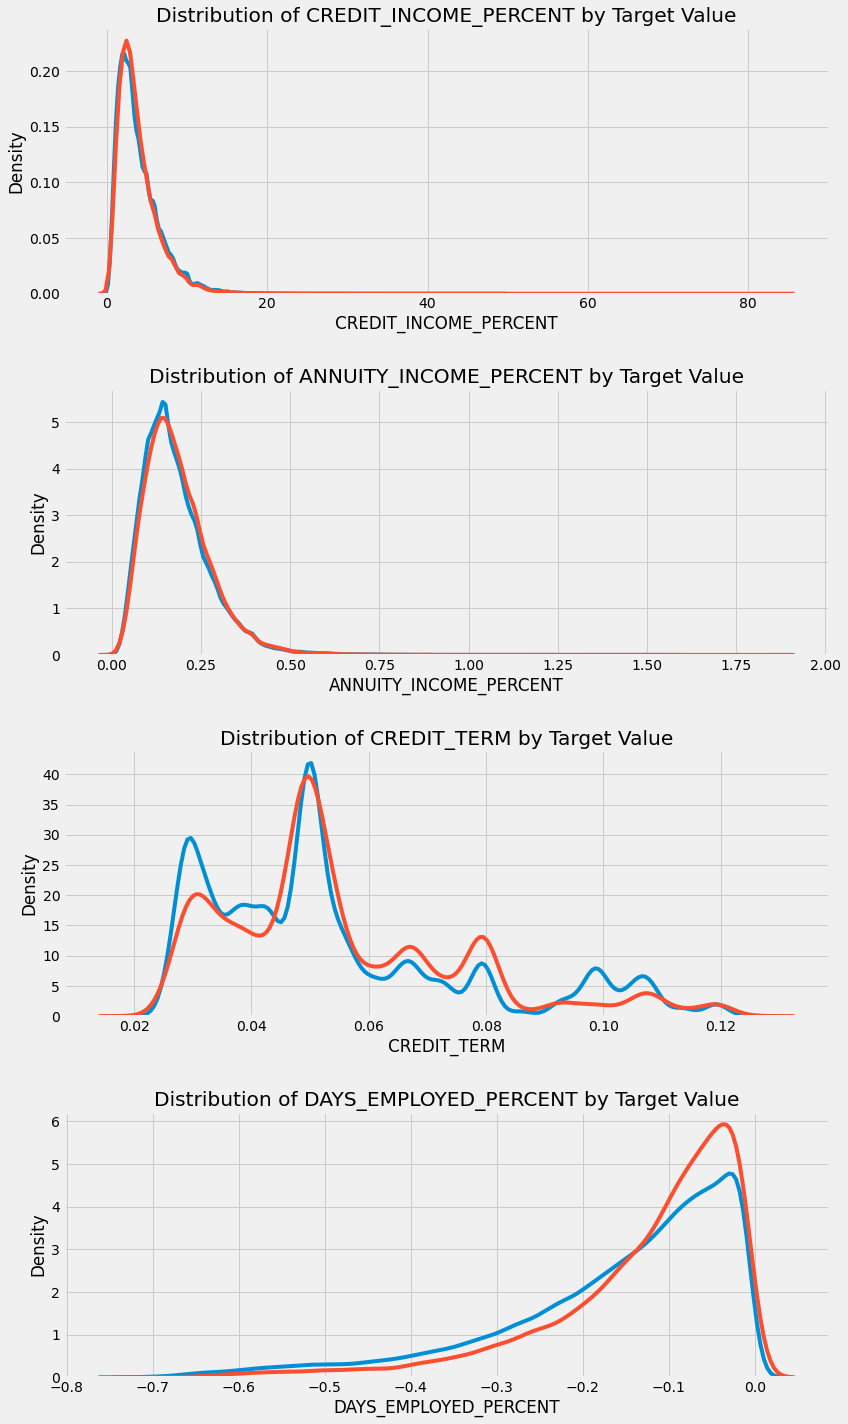

In [44]:
plt.figure(figsize=(12, 20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    plt.subplot(4, 1, i+1)
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 0, feature], label='target == 0')
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 1, feature], label='target = =1')
    
    plt.title('Distribution of %s by Target Value' %feature)
    plt.xlabel('%s' %feature)
    plt.ylabel('Density')

plt.tight_layout(h_pad=2.5)

# Baseline

## Logistic Regression

In [45]:
lg_test = test.copy()
lg_train = train.copy()

In [46]:
if 'TARGET' in lg_train:
    lg_train = lg_train.drop(columns=['TARGET'])
else:
    lg_train = train.copy()
    
features = list(lg_train.columns)

In [47]:
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0, 1)) # 모든 데이터가 0과 1 사이의 값을 가지도록 정규화

imputer.fit(lg_train)
scaler.fit(lg_train)

lg_train = imputer.transform(lg_train)
lg_test = imputer.transform(lg_test)

lg_train = scaler.transform(lg_train)
lg_test = scaler.transform(lg_test)

print('Training data shape :', lg_train.shape)
print('Testing data shape :', lg_test.shape)

Training data shape : (307511, 240)
Testing data shape : (48744, 240)


regularization C를 작게 설정함으로써 오버피팅을 방지한다. 이렇게 regularization을 설정해 주면 단순히 `LogisticRegression`을 설정하는 것보다 더 좋은 결과가 나온다고 한다.

In [48]:
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(lg_train, train_labels)

LogisticRegression(C=0.0001)

대출금 상환 능력을 예측해야 하기 때문에, `predict_proba` 메서드를 사용한다.

In [49]:
log_reg_pred = log_reg.predict_proba(lg_test)[:, 1]

In [50]:
submit = test[['SK_ID_CURR']]

In [51]:
# Submission dataframe
submit = submit.copy()
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.078515
1,100005,0.137926
2,100013,0.082194
3,100028,0.080921
4,100038,0.132618


## Random Forest

Week3에서 공부한 [Bayesian Optimization을 활용한 hyperparameter tuning](https://github.com/Deep-dive-into-Kaggle-and-ML/Kaggle/blob/main/week03/Hyewon/week03.pdf)을 Random Forest에 적용해 보자.

In [89]:
X = train.drop(columns=['TARGET'])
y = train['TARGET']

In [90]:
X_impute = X.copy()
imputer.fit(X_impute)
X_impute = imputer.transform(X_impute)

In [91]:
pbounds = {
    'max_depth' : (10, 20),
    'n_estimators' : (100, 300) 
}

def random_forest_pbounds(max_depth, n_estimators):
    random_forest_params={
        'max_depth' : int(round(max_depth)),
        'n_estimators' : int(round(n_estimators))
    }
    rf = RandomForestClassifier(**random_forest_params)
    
    X_train, X_test, y_train, y_test = train_test_split(X_impute, y, test_size=0.2)
    
    rf.fit(X_train, y_train)
    
    score = accuracy_score(y_test, rf.predict(X_test))
    return score

In [92]:
random_forest_bo = BayesianOptimization(f=random_forest_pbounds, pbounds=pbounds, random_state=0)
random_forest_bo.maximize(init_points=5, n_iter=5)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.9186   |  15.49    |  243.0    |
|  2        |  0.9191   |  16.03    |  209.0    |
|  3        |  0.9188   |  14.24    |  229.2    |
|  4        |  0.9171   |  14.38    |  278.4    |
|  5        |  0.9185   |  19.64    |  176.7    |
|  6        |  0.9184   |  10.0     |  100.0    |
|  7        |  0.9188   |  15.28    |  208.0    |
|  8        |  0.9189   |  18.11    |  211.6    |
|  9        |  0.9196   |  13.68    |  212.2    |
|  10       |  0.9206   |  10.83    |  214.5    |


In [96]:
optimal_params = random_forest_bo.max['params']
optimal_params['max_depth'] = int(optimal_params['max_depth'])
optimal_params['n_estimators'] = int(optimal_params['n_estimators'])
print(optimal_params)

{'max_depth': 10, 'n_estimators': 214}
